Proyek Image Classification: **Shoe vs Sandal vs Boot Dataset**
- Nama:**ERIKA BUDIARTI**
- Email: erika.analytic@gmail.com
- Id Dicoding:erika_budiarti

# **Menghubungkan KAGGLE dan Google Colaboratory**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p /content/gdrive/My\ Drive/Kaggle
!mv kaggle.json /content/gdrive/My\ Drive/Kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 92% 43.0M/47.0M [00:01<00:00, 36.0MB/s]
100% 47.0M/47.0M [00:01<00:00, 26.2MB/s]


In [ ]:
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

# **Import Library**

In [ ]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l1, l2, l1_l2

2.13.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import random
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pathlib

# **Split Folder**

In [ ]:
# Menyimpan dataset gambar dalam directory "base_dir"
base_dir = '/content/Shoe vs Sandal vs Boot Dataset'

In [ ]:
# Menampilkan jumlah gambar untuk setiap kelas
boot_dir = '/content/Shoe vs Sandal vs Boot Dataset/Boot'
sandal_dir = '/content/Shoe vs Sandal vs Boot Dataset/Sandal'
shoe_dir = '/content/Shoe vs Sandal vs Boot Dataset/Shoe'

boot_images = len(os.listdir(boot_dir))
sandal_images = len(os.listdir(sandal_dir))
shoe_images = len(os.listdir(shoe_dir))

print(f'Number of Boot images: {boot_images}')
print(f'Number of Sandal images: {sandal_images}')
print(f'Number of Shoe images: {shoe_images}')

Number of Boot images: 5000
Number of Sandal images: 5000
Number of Shoe images: 5000


In [ ]:
# Menampilkan resolusi gambar dengan menggunakan sample dari kelas "Sandal"

def display_images_with_different_resolution_sandal(sandal_dir, num_images=2):
    print("Class: Sandal")

    image_files = [os.path.join(sandal_dir, file) for file in os.listdir(sandal_dir) if file.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

    resolution_dict = {}
    for path in image_files:
        image_name = Image.open(path)
        width, height = image_name.size
        resolution = (width, height)
        if resolution not in resolution_dict:
            resolution_dict[resolution] = []
        resolution_dict[resolution].append(path)

    for resolution, paths in resolution_dict.items():
        if len(paths) >= num_images:
            random_images = random.sample(paths, num_images)
            print(f"Resolution: {resolution[0]} x {resolution[1]}")
            for path in random_images:
                print(f"  Image: {path}\n")
        else:
            print(f"Resolution: {resolution[0]} x {resolution[1]}")
            for path in paths:
                print(f"  Image: {path}\n")

display_images_with_different_resolution_sandal(sandal_dir, num_images=2)

Class: Sandal
Resolution: 136 x 102
  Image: /content/Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (1218).jpg

  Image: /content/Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (3174).jpg

Resolution: 135 x 102
  Image: /content/Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (91).jpg

  Image: /content/Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (28).jpg



In [ ]:
# Data validasi 20%, data pelatihan 80%
data_generator = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

In [ ]:
# Menampilkan jumlah data pelatihan dan data validasi
train_dir = '/tmp/images/train'
train_generator = data_generator.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset="training"
)

validation_dir = '/tmp/images/val'
validation_generator = data_generator.flow_from_directory(
       base_dir,
       target_size=(224, 224),
       batch_size=32,
       class_mode='categorical',
       subset="validation",
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


# **Pembuatan Model**

In [ ]:
# Mendefinisikan model
model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dense(256, activation = 'relu'),
            tf.keras.layers.Dense(3, activation = 'softmax')
])

In [ ]:
# Mendefinisikan Callback
class iCallback(tf.keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model

    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') >= 0.99 and
            logs.get('accuracy') >= 0.99):
            self.model.stop_training = True

reduce_lr_val_accuracy_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

reduce_lr_accuracy_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

callback_model = [iCallback(model), reduce_lr_val_accuracy_callback, reduce_lr_accuracy_callback]

In [ ]:
# Mendefinisikan Loss
loss = CategoricalCrossentropy()

In [ ]:
# Mendefinisikan Optimizer
optimizer = Adam()

In [ ]:
# Kompilasi Model
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

# **Training Data**

In [ ]:
history = model.fit(
    train_generator,
    batch_size = 32,
    epochs = 25,
    validation_data = validation_generator,
    verbose = 2,
    callbacks = callback_model
    )

Epoch 1/25
375/375 - 1119s - loss: 0.4144 - accuracy: 0.8437 - val_loss: 0.1819 - val_accuracy: 0.9370 - lr: 0.0010 - 1119s/epoch - 3s/step
Epoch 2/25
375/375 - 1114s - loss: 0.1359 - accuracy: 0.9517 - val_loss: 0.1468 - val_accuracy: 0.9493 - lr: 0.0010 - 1114s/epoch - 3s/step
Epoch 3/25
375/375 - 1116s - loss: 0.0705 - accuracy: 0.9757 - val_loss: 0.1213 - val_accuracy: 0.9577 - lr: 0.0010 - 1116s/epoch - 3s/step
Epoch 4/25
375/375 - 1105s - loss: 0.0591 - accuracy: 0.9797 - val_loss: 0.1789 - val_accuracy: 0.9423 - lr: 0.0010 - 1105s/epoch - 3s/step
Epoch 5/25
375/375 - 1101s - loss: 0.0474 - accuracy: 0.9835 - val_loss: 0.2176 - val_accuracy: 0.9457 - lr: 0.0010 - 1101s/epoch - 3s/step
Epoch 6/25

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
375/375 - 1080s - loss: 0.0208 - accuracy: 0.9915 - val_loss: 0.2118 - val_accuracy: 0.9517 - lr: 2.0000e-04 - 1080s/epoch - 3s/step
Epoch 7/25
375/375 - 1092s - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.227

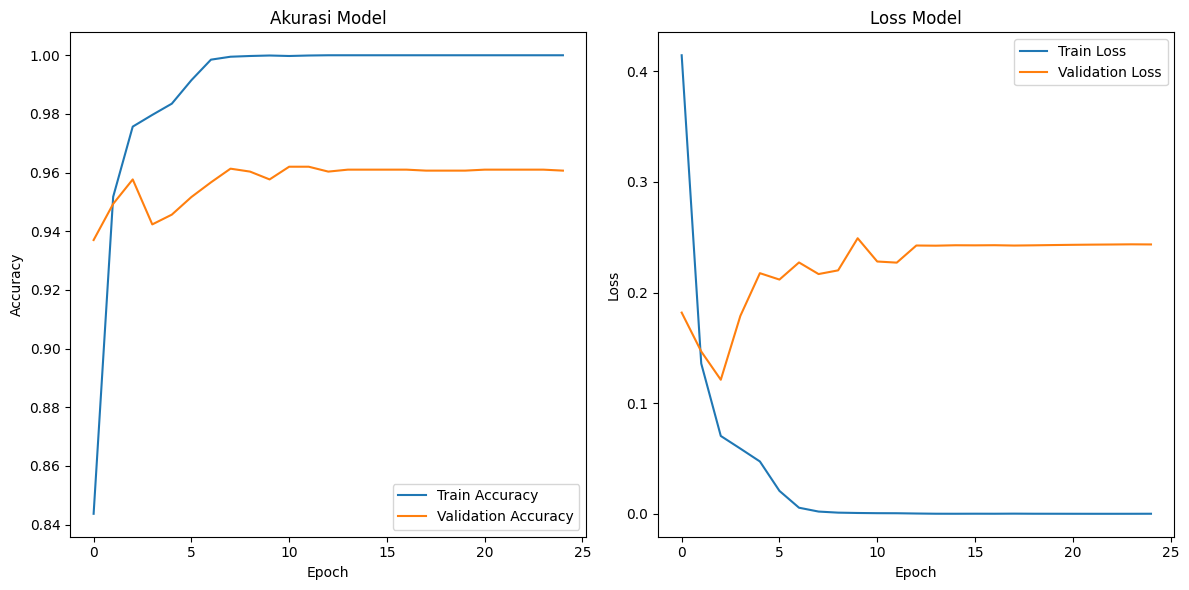

In [ ]:
# Data akurasi
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Data loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot pertama (Akurasi)
axes[0].plot(train_accuracy, label='Train Accuracy')
axes[0].plot(val_accuracy, label='Validation Accuracy')
axes[0].set_title('Akurasi Model')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')

# Plot kedua (Loss)
axes[1].plot(train_loss, label='Train Loss')
axes[1].plot(val_loss, label='Validation Loss')
axes[1].set_title('Loss Model')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

# **Mengubah Model**

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('imej.tflite')
tflite_model_file.write_bytes(tflite_model)

102977508